In [1]:
!pip3 install -U nltk

Requirement already up-to-date: nltk in c:\users\rangapotluri\anaconda3\envs\tensorflow-gpu\lib\site-packages (3.5)


In [2]:
!pip3 install -U stanfordnlp

Requirement already up-to-date: stanfordnlp in c:\users\rangapotluri\anaconda3\envs\tensorflow-gpu\lib\site-packages (0.2.0)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanfordnlp

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


warnings.simplefilter("ignore", UserWarning)

In [4]:
stanfordnlp.download('en')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)
Y

Default download directory: C:\Users\RangaPotluri\stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: C:\Users\RangaPotluri\stanfordnlp_resources\en_ewt_models.zip


  0%|                                                                                       | 0.00/235M [00:09<?, ?B/s]


KeyboardInterrupt: 

In [4]:
import pandas as pd 
import numpy as np
import string
import re
import tokenize

# for word counts
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
with open("negative-words.txt", "r") as f:
    neg_text = f.read() # neg_text is string
neg_tokens = neg_text.split("\n")# taking all neg words into a list
neg_tokens[-1:] = [] # removing last empty string
print(neg_tokens[:10])

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [6]:
with open("positive-words.txt", "r") as f:
    pos_text = f.read() # neg_text is string
pos_tokens = pos_text.split("\n")# taking all pos words into a list
pos_tokens[-1:] = [] # removing last empty string
print(pos_tokens[:10])

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']


In [7]:
# Import datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [8]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [9]:
train.info()# there are null values in the train data. we can drop those null observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [10]:
train[train['text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [11]:
train.dropna(inplace=True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [13]:
test.info() # there are no null values in test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [14]:
# there are three class labels. let us check the frequency of the class labels
temp = train.groupby('sentiment').count()['text'].sort_values(ascending = False)
temp

sentiment
neutral     11117
positive     8582
negative     7781
Name: text, dtype: int64

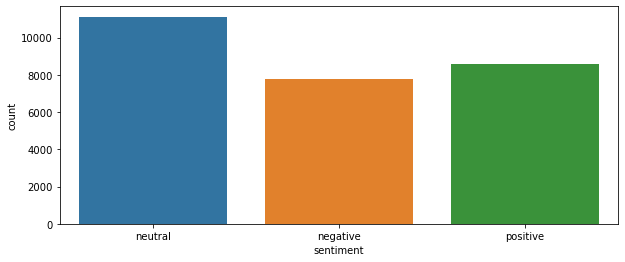

In [15]:
# graphical distribution of class label in train set 
plt.figure(figsize=(10,4))
sns.countplot(x='sentiment',data=train)

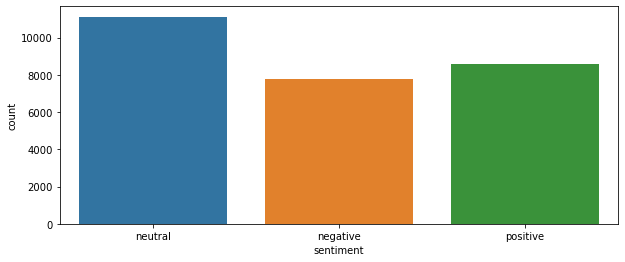

In [16]:
#Visualization of class label in test set
plt.figure(figsize=(10,4))
sns.countplot(x='sentiment',data=train)
# if you observe in both train and test neutral is dominating both positive and negative
# But the distribution of +ve and -ve is same in both train and test

In [17]:
# there are some special symbols in text and selected_text, these  are to be processed
def clean_text(txt):
    
    txt = str(txt).lower() # Converting into lower
    txt = re.sub('https?://\S+|www\.\S+', '', txt)# removing links
    txt = re.sub('<.*?>+', '', txt)# removing angular brackets
    txt = re.sub('\n', '', txt) # removing new lines 
    txt = re.sub('\w*\d\w*', '', txt) # remove words containing numbers
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)# remove punctuation
    txt = re.sub('\[.*?\]', '', txt)# removing square brackets
    
    return txt

In [18]:
import re
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [19]:
df_dict = pd.DataFrame()
df_dict = train.filter(['text','sentiment','selected_text'], axis=1)
df_dict['dict_word']= ""

In [20]:
print(len(train))

27480


In [21]:
# comparing tweet words with dictionary words and extracting pos/neg words into new column 'dict_word'
for i  in range(len(train)+1): 
    if(i == 314):
        continue;
    tweet = train['text'][i]
    tweet_token = re.findall(r'\b\w[\w-]*\b', tweet.lower())
    dict_words = []
    flag = 0
    for word in tweet_token:
        if word in pos_tokens:
            dict_words.append(word)
            flag = 1
                    
        if word in neg_tokens:
            dict_words.append(word)
            flag = 1
    if flag == 0:
        df_dict['dict_word'][i] = tweet 
    else:
        str1 = ' '.join(str(e) for e in dict_words)
        df_dict['dict_word'][i] = str1
    

Some observations:
1)Eventhough there are multiple pos/neg words always 'selected-text' is taking only the first pos/neg word. eg: tweet 6     
2)Even the words are combined 'selected-text' is able to identify pos/neg words.eg: tweet 30    
3)Eventhough the tweet has pos/neg word(s), in some cqases it is considering that as 'neutral'

In [22]:
df_dict.head(45)

,text,sentiment,selected_text,dict_word
0,id have responded if i were going,neutral,id have responded if i were going,id have responded if i were going
1,sooo sad i will miss you here in san diego,negative,sooo sad,sad miss
2,my boss is bullying me,negative,bullying me,bullying
3,what interview leave me alone,negative,leave me alone,what interview leave me alone
4,sons of why couldnt they put them on the rel...,negative,sons of,sons of why couldnt they put them on the rel...
5,some shameless plugging for the best rangers...,neutral,some shameless plugging for the best rangers...,shameless best
6,feedings for the baby are fun when he is all ...,positive,fun,fun smiles
7,soooo high,neutral,soooo high,soooo high
8,both of you,neutral,both of you,both of you
9,journey wow u just became cooler hehe is tha...,positive,wow u just became cooler,wow


In [23]:
df_dict['dict_word_dependent'] = " "

In [24]:
def sentiment_analysis(tweet, stop_words, nlp,dictword,sentiment):
    
    if(sentiment == 'neutral'):
        return tweet

    tweetList = nltk.sent_tokenize(tweet)# Splitting the text into sentences
    
    #dictword = df_dict['dict_word'][k]# most of the selected_text are taking the first pos/neg word
    neg_pos_word = dictword[0]

    fcluster = []
    totalfeatureList = []
    finalcluster = []
    dic = {}
    word_dep = []

    for line in tweetList:

        tweet_list = nltk.word_tokenize(line)
        POSList = nltk.pos_tag(tweet_list) # Doing Part-of-Speech Tagging to each word

        newwordList = []
        flag = 0
        if(len(POSList) == 1):
            newwordList.append(tweet)
            
        for i in range(0,len(POSList)-1):
            if(POSList[i][1]=="NN" and POSList[i+1][1]=="NN"): # If two consecutive words are Nouns then they are joined together
                newwordList.append(POSList[i][0]+POSList[i+1][0])
                flag=1
            else:
                if(flag==1):
                    flag=0
                    continue
                newwordList.append(POSList[i][0])
                if(i==len(POSList)-2):
                    newwordList.append(POSList[i+1][0])

        finaltxt = ' '.join(word for word in newwordList) 
        new_txt_list = nltk.word_tokenize(finaltxt)
        wordsList = [w for w in new_txt_list if not w in stop_words]
        POSList = nltk.pos_tag(wordsList)

        doc = nlp(finaltxt) # Object of Stanford NLP Pipeleine
        
        # Getting the dependency relations betwwen the words
        dep_node = []
        for dep_edge in doc.sentences[0].dependencies:
            dep_node.append([dep_edge[2].text, dep_edge[0].index, dep_edge[1]])

        # Coverting it into appropriate format
        for i in range(0, len(dep_node)):
            if (int(dep_node[i][1]) != 0):
                if(len(newwordList) < len(POSList)):
                    dep_node[i][1] = newwordList[(int(dep_node[i][1]) - 2)]
                
        for i in range(len(dep_node)):
            for j in range(len(dep_node[0])):
                if(neg_pos_word in dep_node[i][j]):
                    word_dep = dep_node[i][0]+' '+dep_node[i][1]
        
    
    return word_dep

In [25]:
from tqdm import tqdm
nlp = stanfordnlp.Pipeline()
stop_words = set(stopwords.words('english'))
for i in tqdm(range(len(df_dict))):
    if(i == 314):
        continue;
    tweet = df_dict['text'][i]
    dictword = df_dict['dict_word'][i]
    sentiment = df_dict['sentiment'][i]
    dict_word_dep = sentiment_analysis(tweet, stop_words, nlp,dictword,sentiment)
    if(dict_word_dep == []):
        df_dict['dict_word_dependent'][i] = tweet
    else:
        df_dict['dict_word_dependent'][i] = dict_word_dep

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\RangaPotluri\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\RangaPotluri\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tagger.pt', 'pretrain_path': 'C:\\Users\\RangaPotluri\\stanfordnlp_resources\\en_ewt_models\\en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': 'C:\\Users\\RangaPotluri\\stanfordnlp_resources\\en_ewt_models\\en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': 'C:\\Users\\RangaPotluri\\stanfordnlp_resources\\en_ewt_models\\en_ewt_parser.pt', 

  0%|                                                                                        | 0/27480 [00:00<?, ?it/s]

Done loading processors!
---


100%|████████████████████████████████████████████████████████████████████████████| 27480/27480 [39:53<00:00, 11.48it/s]


In [27]:
df_dict['dict_word_dependent'] = df_dict['dict_word_dependent'].str.replace('\d+', '')

In [28]:
df_dict.head(100)

,text,sentiment,selected_text,dict_word,dict_word_dependent
0,id have responded if i were going,neutral,id have responded if i were going,id have responded if i were going,id have responded if i were going
1,sooo sad i will miss you here in san diego,negative,sooo sad,sad miss,san
2,my boss is bullying me,negative,bullying me,bullying,me
3,what interview leave me alone,negative,leave me alone,what interview leave me alone,what interview leave me alone
4,sons of why couldnt they put them on the rel...,negative,sons of,sons of why couldnt they put them on the rel...,sons of why couldnt they put them on the rel...
...,...,...,...,...,...
95,happy mothers day to all you mums out there,positive,happy mothers day to all you mums out there,happy,there
96,caseys gone but why so she piddled a little o...,negative,freaked,caseys gone but why so she piddled a little o...,caseys gone but why so she piddled a little o...
97,hemp cloth is marvelous but unfortunately no,negative,unfortunately,marvelous unfortunately,marvelous
98,gonna read a story bout adam lambert online th...,neutral,gonna read a story bout adam lambert online th...,gonna read a story bout adam lambert online th...,gonna read a story bout adam lambert online th...


In [58]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    if (len(a) == 0):
        return 0
    return float(len(c)) / (len(a) + len(b) - len(c))

In [59]:
df_dict['jaccard'] = df_dict.apply(lambda x: jaccard(x['selected_text'], x['dict_word_dependent']), axis = 1)

print('The jaccard score is:', np.mean(df_dict['jaccard']))

The jaccard score is: 0.5105726804219353
